<a href="https://colab.research.google.com/github/mavillan/gb-vpp/blob/main/models/gb-vpp-lstm-pl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive', force_remount=True)

!pip install --upgrade kaggle > /dev/null 2>&1
!mkdir -p ~/.kaggle/ && cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Mounted at /content/drive


In [2]:
!pip uninstall -y tensorflow 
!pip install tensorflow==2.4.3 > /dev/null 2>&1

import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Found existing installation: tensorflow 2.4.3
Uninstalling tensorflow-2.4.3:
  Successfully uninstalled tensorflow-2.4.3
Tensorflow version 2.4.3
Running on TPU  ['10.96.19.210:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.96.19.210:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.96.19.210:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [3]:
!mkdir -p input/
!kaggle competitions download -c ventilator-pressure-prediction -p input/ --force

!unzip -o input/sample_submission.csv.zip -d input/
!unzip -o input/train.csv.zip -d input/
!unzip -o input/test.csv.zip -d input/

 96% 133M/139M [00:00<00:00, 168MB/s]
100% 139M/139M [00:00<00:00, 204MB/s]
  0% 0.00/8.50M [00:00<?, ?B/s]
100% 8.50M/8.50M [00:00<00:00, 78.2MB/s]
 86% 65.0M/75.4M [00:00<00:00, 142MB/s]
100% 75.4M/75.4M [00:00<00:00, 217MB/s]
Archive:  input/sample_submission.csv.zip
  inflating: input/sample_submission.csv  
Archive:  input/train.csv.zip
  inflating: input/train.csv         
Archive:  input/test.csv.zip
  inflating: input/test.csv          


In [4]:
!mkdir -p subs/
!kaggle datasets download -d mavillan/gb-vpp-subs -p subs --force --unzip

 62% 33.0M/53.3M [00:00<00:00, 64.1MB/s]
100% 53.3M/53.3M [00:00<00:00, 178MB/s] 


In [5]:
input_path = "input"
subs_path = "/content/drive/MyDrive/kaggle/gb-vpp/subs"
results_path = "/content/drive/MyDrive/kaggle/gb-vpp/results"
artifacts_path = "/content/drive/MyDrive/kaggle/gb-vpp/artifacts"

***

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import Callback

from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import RobustScaler, normalize
from sklearn.model_selection import train_test_split, GroupKFold, KFold

from IPython.display import display

***
## data preparation

In [7]:
SEQ_LEN = 80

In [8]:
train_raw = pd.read_csv(f'{input_path}/train.csv')
test_raw = pd.read_csv(f'{input_path}/test.csv')
submission = pd.read_csv(f'{input_path}/sample_submission.csv')

pseudo_labels = pd.read_csv("subs/public_0.157.csv")

In [9]:
mapping = {j:i for i,j in enumerate(train_raw.breath_id.unique())}
train_raw["breath_id"] = train_raw.breath_id.map(mapping)

if SEQ_LEN < 80:

    train_raw = (
        train_raw
        .sort_values(["breath_id","time_step"])
        .groupby("breath_id")
        .head(SEQ_LEN)
        .reset_index(drop=True)
    )
    test_raw = (
        test_raw
        .sort_values(["breath_id","time_step"])
        .groupby("breath_id")
        .head(SEQ_LEN)
        .reset_index(drop=True)
    )

In [10]:
def compute_feats(dataframe):
    dataframe = dataframe.copy()

    # time features
    dataframe["time_diff"] = dataframe.groupby("breath_id")["time_step"].diff()
    dataframe['time_since_expiratory']= dataframe['time_step'] * dataframe['u_out']

    # lag features
    lags = [1,2]
    for lag in lags:
        dataframe[f"u_in_lag{lag}"] = dataframe.groupby("breath_id")["u_in"].shift(lag).fillna(0)

    # stats on u_in
    dataframe["u_in_cumsum"] = dataframe.groupby("breath_id")["u_in"].cumsum()
    dataframe['u_in_cummean'] =dataframe['u_in_cumsum'] / (dataframe.groupby("breath_id")["id"].cumcount()+1)
    #dataframe['u_in_last'] = dataframe.groupby('breath_id')['u_in'].transform('last')
    dataframe['cross1']= dataframe['u_in'] * dataframe['u_out']
    dataframe['cross2']= dataframe['u_in'] * (1 - dataframe['u_out'])

    dataframe['area'] = dataframe['time_step'] * dataframe['u_in']
    dataframe['area'] = dataframe.groupby('breath_id')['area'].cumsum()
    
    dataframe['vol_diff'] = (dataframe['time_diff']*dataframe['u_in']).fillna(0)
    dataframe['vol_diff_cumsum'] = dataframe.groupby('breath_id')['vol_diff'].cumsum()

    # gradients of u_in
    def compute_grad_1st(df):
        return np.gradient(df.u_in, 100*df.time_step)
    def compute_grad_2nd(df):
        return np.gradient(df.grad_1st, 100*df.time_step)

    gb_result = dataframe.groupby("breath_id").apply(compute_grad_1st)
    dataframe["grad_1st"] = np.concatenate(gb_result.values)
    gb_result = dataframe.groupby("breath_id").apply(compute_grad_2nd)
    dataframe["grad_2nd"] = np.concatenate(gb_result.values)

    # nan filling
    dataframe["time_diff"] = dataframe["time_diff"].fillna(method="bfill")
    
    # ohe of R&C values    
    dataframe['R'] = dataframe['R'].astype(str)
    dataframe['C'] = dataframe['C'].astype(str)
    dataframe['RC'] = dataframe['R']+dataframe['C']
    dataframe = pd.get_dummies(dataframe)
    return dataframe

train = compute_feats(train_raw)
test  = compute_feats(test_raw)


In [11]:
train_targets = train[['pressure']].to_numpy().reshape(-1, SEQ_LEN)

test = pd.merge(test, pseudo_labels, how="inner", on="id")
test_targets = test[['pressure']].to_numpy().reshape(-1, SEQ_LEN)

cols_to_exclude_train = exclude = ["id","breath_id","pressure"]
cols_to_exclude_test = exclude = ["id","breath_id","pressure"]

train.drop(cols_to_exclude_train, axis=1, inplace=True)
test.drop(cols_to_exclude_test, axis=1, inplace=True)

In [12]:
scaler = RobustScaler()
train = scaler.fit_transform(train)
test = scaler.transform(test)

In [13]:
train = train.reshape(-1, SEQ_LEN, train.shape[-1])
test = test.reshape(-1, SEQ_LEN, train.shape[-1])

***
## model training

In [14]:
def build_model(input_dim):
    with tpu_strategy.scope():   
        inputs = layers.Input(shape = input_dim)
        
        h1 = layers.Bidirectional(layers.LSTM(1024, return_sequences=True))(inputs)
        h2 = layers.Bidirectional(layers.LSTM(512, return_sequences=True))(h1)
        h3 = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(h2)
        h4 = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(h3) 
                
        hcat = layers.Concatenate()([h3,h4])
        hcat = layers.Dropout(0.1)(hcat)
        out = layers.Dense(128, activation = 'selu')(hcat)
        out = layers.Dense(1)(out)
        
        model = keras.Model(inputs, out)
        model.compile(optimizer="adam", loss="mae")
           
    return model  

----------------------------------- Fold: 1 ------------------------------------
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80, 31)]     0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 80, 2048)     8650752     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 80, 1024)     10489856    bidirectional[0][0]              
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 80, 512)      2623488     bidirectional_1[0][0]            
_____________

None

Epoch 1/250

Epoch 00001: LearningRateScheduler reducing learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
109/109 [==============================] - 77s 440ms/step - loss: 3.7619 - val_loss: 0.7399
Epoch 2/250

Epoch 00002: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009992191, shape=(), dtype=float32).
109/109 [==============================] - 21s 194ms/step - loss: 0.7110 - val_loss: 0.5630
Epoch 3/250

Epoch 00003: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009984388, shape=(), dtype=float32).
109/109 [==============================] - 21s 194ms/step - loss: 0.5563 - val_loss: 0.5646
Epoch 4/250

Epoch 00004: LearningRateScheduler reducing learning rate to tf.Tensor(0.000997659, shape=(), dtype=float32).
109/109 [==============================] - 21s 195ms/step - loss: 0.4890 - val_loss: 0.4496
Epoch 5/250

Epoch 00005: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009968799, shape=(), dtype=float32).
109/109 [===========

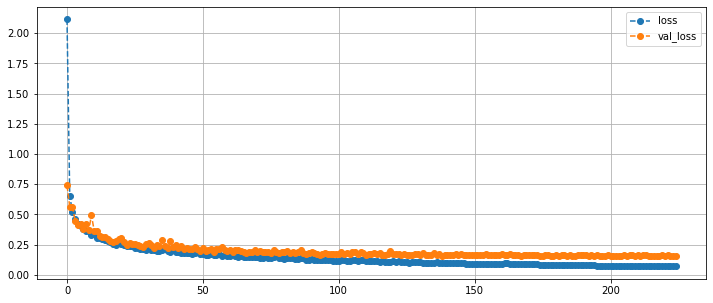

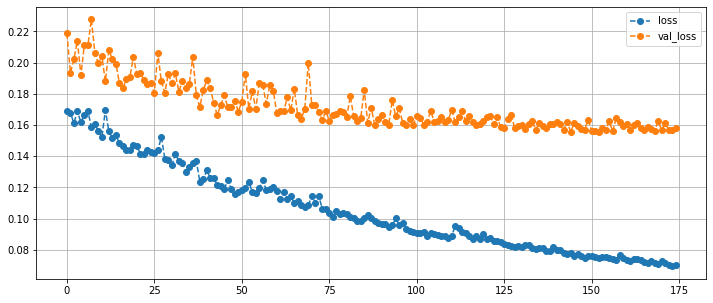

----------------------------------- Fold: 2 ------------------------------------
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 80, 31)]     0                                            
__________________________________________________________________________________________________
bidirectional_4 (Bidirectional) (None, 80, 2048)     8650752     input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional_5 (Bidirectional) (None, 80, 1024)     10489856    bidirectional_4[0][0]            
__________________________________________________________________________________________________
bidirectional_6 (Bidirectional) (None, 80, 512)      2623488     bidirectional_5[0][0]            
___________

None

Epoch 1/250

Epoch 00001: LearningRateScheduler reducing learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
109/109 [==============================] - 76s 438ms/step - loss: 3.6742 - val_loss: 0.8837
Epoch 2/250

Epoch 00002: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009992191, shape=(), dtype=float32).
109/109 [==============================] - 21s 194ms/step - loss: 0.7722 - val_loss: 0.7090
Epoch 3/250

Epoch 00003: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009984388, shape=(), dtype=float32).
109/109 [==============================] - 21s 195ms/step - loss: 0.5703 - val_loss: 0.5401
Epoch 4/250

Epoch 00004: LearningRateScheduler reducing learning rate to tf.Tensor(0.000997659, shape=(), dtype=float32).
109/109 [==============================] - 21s 195ms/step - loss: 0.4952 - val_loss: 0.5051
Epoch 5/250

Epoch 00005: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009968799, shape=(), dtype=float32).
109/109 [===========

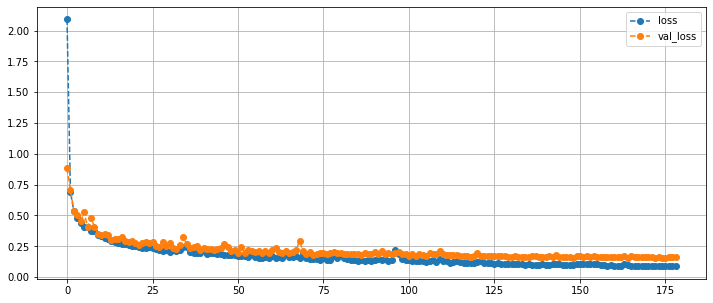

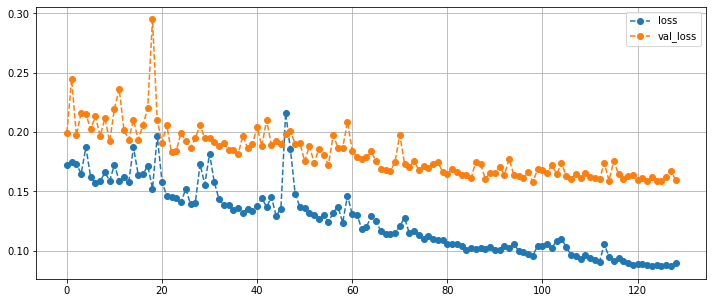

----------------------------------- Fold: 3 ------------------------------------
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 80, 31)]     0                                            
__________________________________________________________________________________________________
bidirectional_8 (Bidirectional) (None, 80, 2048)     8650752     input_3[0][0]                    
__________________________________________________________________________________________________
bidirectional_9 (Bidirectional) (None, 80, 1024)     10489856    bidirectional_8[0][0]            
__________________________________________________________________________________________________
bidirectional_10 (Bidirectional (None, 80, 512)      2623488     bidirectional_9[0][0]            
___________

None

Epoch 1/250

Epoch 00001: LearningRateScheduler reducing learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
109/109 [==============================] - 76s 437ms/step - loss: 3.6838 - val_loss: 0.7865
Epoch 2/250

Epoch 00002: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009992191, shape=(), dtype=float32).
109/109 [==============================] - 21s 195ms/step - loss: 0.7021 - val_loss: 0.6618
Epoch 3/250

Epoch 00003: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009984388, shape=(), dtype=float32).
109/109 [==============================] - 21s 194ms/step - loss: 0.5963 - val_loss: 0.4843
Epoch 4/250

Epoch 00004: LearningRateScheduler reducing learning rate to tf.Tensor(0.000997659, shape=(), dtype=float32).
109/109 [==============================] - 21s 196ms/step - loss: 0.4734 - val_loss: 0.4591
Epoch 5/250

Epoch 00005: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009968799, shape=(), dtype=float32).
109/109 [===========

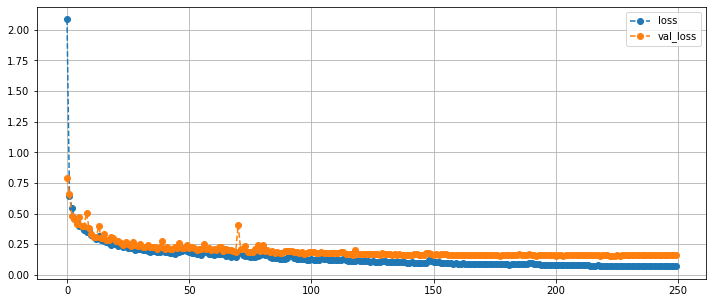

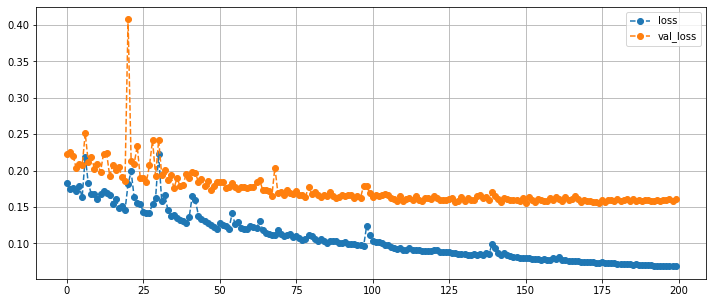

----------------------------------- Fold: 4 ------------------------------------
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 80, 31)]     0                                            
__________________________________________________________________________________________________
bidirectional_12 (Bidirectional (None, 80, 2048)     8650752     input_4[0][0]                    
__________________________________________________________________________________________________
bidirectional_13 (Bidirectional (None, 80, 1024)     10489856    bidirectional_12[0][0]           
__________________________________________________________________________________________________
bidirectional_14 (Bidirectional (None, 80, 512)      2623488     bidirectional_13[0][0]           
___________

None

Epoch 1/250

Epoch 00001: LearningRateScheduler reducing learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
109/109 [==============================] - 77s 434ms/step - loss: 3.3500 - val_loss: 0.8416
Epoch 2/250

Epoch 00002: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009992191, shape=(), dtype=float32).
109/109 [==============================] - 21s 194ms/step - loss: 0.7465 - val_loss: 0.6266
Epoch 3/250

Epoch 00003: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009984388, shape=(), dtype=float32).
109/109 [==============================] - 21s 194ms/step - loss: 0.5561 - val_loss: 0.5652
Epoch 4/250

Epoch 00004: LearningRateScheduler reducing learning rate to tf.Tensor(0.000997659, shape=(), dtype=float32).
109/109 [==============================] - 21s 195ms/step - loss: 0.5098 - val_loss: 0.4594
Epoch 5/250

Epoch 00005: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009968799, shape=(), dtype=float32).
109/109 [===========

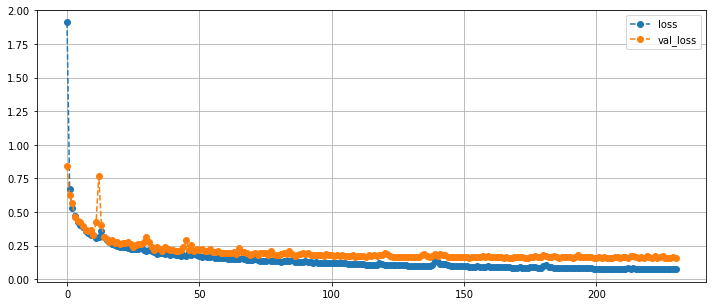

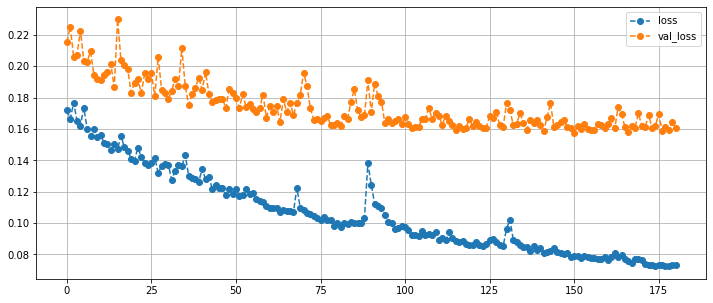

----------------------------------- Fold: 5 ------------------------------------
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 80, 31)]     0                                            
__________________________________________________________________________________________________
bidirectional_16 (Bidirectional (None, 80, 2048)     8650752     input_5[0][0]                    
__________________________________________________________________________________________________
bidirectional_17 (Bidirectional (None, 80, 1024)     10489856    bidirectional_16[0][0]           
__________________________________________________________________________________________________
bidirectional_18 (Bidirectional (None, 80, 512)      2623488     bidirectional_17[0][0]           
___________

None

Epoch 1/250

Epoch 00001: LearningRateScheduler reducing learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
109/109 [==============================] - 75s 431ms/step - loss: 3.4401 - val_loss: 0.9278
Epoch 2/250

Epoch 00002: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009992191, shape=(), dtype=float32).
109/109 [==============================] - 21s 195ms/step - loss: 0.7613 - val_loss: 0.6099
Epoch 3/250

Epoch 00003: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009984388, shape=(), dtype=float32).
109/109 [==============================] - 21s 195ms/step - loss: 0.5657 - val_loss: 0.5257
Epoch 4/250

Epoch 00004: LearningRateScheduler reducing learning rate to tf.Tensor(0.000997659, shape=(), dtype=float32).
109/109 [==============================] - 21s 195ms/step - loss: 0.4858 - val_loss: 0.4841
Epoch 5/250

Epoch 00005: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009968799, shape=(), dtype=float32).
109/109 [===========

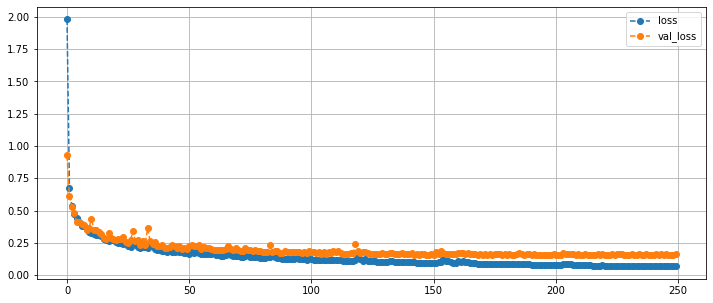

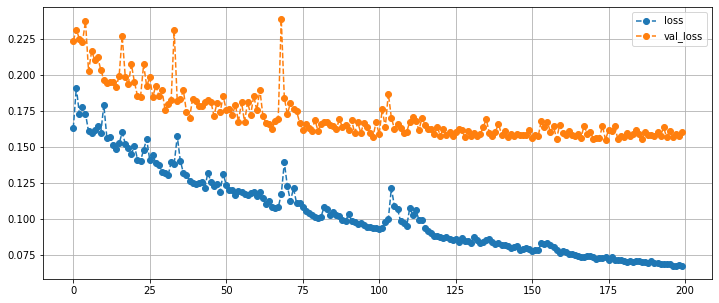

In [15]:
EPOCH = 250
BATCH_SIZE = 1024

kf = KFold(n_splits=5, shuffle=True, random_state=2021)
models_by_fold = list()

oof = train_raw[["id","breath_id","u_out","pressure"]].copy()

for fold, (train_idx,valid_idx) in enumerate(kf.split(train)):

    print(f" Fold: {fold+1} ".center(80, "-"))
    X_train, X_valid = train[train_idx], train[valid_idx]
    y_train, y_valid = train_targets[train_idx], train_targets[valid_idx]

    # PL augmentation
    X_train = np.concatenate([X_train, test], axis=0)
    y_train = np.concatenate([y_train, test_targets], axis=0)

    model = build_model(input_dim=train.shape[-2:])
    display(model.summary())

    scheduler = ExponentialDecay(
        initial_learning_rate=1e-3, 
        decay_steps=EPOCH*((len(train)*0.8)/BATCH_SIZE), 
        decay_rate=1e-5
    )
    lr = LearningRateScheduler(scheduler, verbose=1)
    es = EarlyStopping(
        monitor='val_loss', 
        mode='min', 
        patience=30, 
        verbose=1,
        restore_best_weights=True,
    )
    history = model.fit(
        X_train, 
        y_train, 
        validation_data=(X_valid, y_valid), 
        epochs=EPOCH, 
        batch_size=BATCH_SIZE, 
        callbacks=[lr,es],
        verbose=1,
    )
    models_by_fold.append(model)

    # generate the oof predictions
    x_valid_tf = tf.convert_to_tensor(X_valid, dtype=tf.float32)
    oof_preds = model.call(x_valid_tf, training=False).numpy().squeeze()
    idx = oof.query("breath_id in @valid_idx").index
    oof.loc[idx, "pred"] = oof_preds.ravel()

    plt.figure(figsize=(12,5))
    plt.plot(history.history["loss"], "o--", label="loss")
    plt.plot(history.history["val_loss"], "o--", label="val_loss")
    plt.grid()
    plt.legend(loc="best")
    plt.show()
    
    plt.figure(figsize=(12,5))
    plt.plot(history.history["loss"][50:], "o--", label="loss")
    plt.plot(history.history["val_loss"][50:], "o--", label="val_loss")
    plt.grid()
    plt.legend(loc="best")
    plt.show()

In [16]:
print("mae:", oof.eval("abs(pressure - pred)").mean())
print("mae inspiratory:", oof.query("u_out == 0").eval("abs(pressure - pred)").mean())
print("mae expiratory :", oof.query("u_out == 1").eval("abs(pressure - pred)").mean())

mae: 0.1584655923419512
mae inspiratory: 0.17314587587616617
mae expiratory : 0.1494851457644678


lstm_pl_v2
- mae: 0.1584655923419512
- mae inspiratory: 0.17314587587616617
- mae expiratory : 0.1494851457644678

lstm_pl_v1
- mae: 0.15838549821684894
- mae inspiratory: 0.17731654175485345
- mae expiratory : 0.14680471200411457

***
## sub generation

In [17]:
all_preds = list()
test_tf = tf.convert_to_tensor(test, dtype=tf.float32)

for model in models_by_fold:
    preds = model.call(test_tf, training=False).numpy().squeeze().ravel()
    all_preds.append(preds)

test_raw["pressure"] = np.mean(all_preds, axis=0)

In [18]:
sub = pd.merge(submission["id"], test_raw[["id","pressure"]], how="left", on="id")
sub["pressure"] = sub["pressure"].fillna(0)
sub.to_csv(f"{subs_path}/sub_lstm.csv", index=False)

In [19]:
oof.to_csv(f"{results_path}/oof_lstm.csv", index=False)

***